#ECE 4424 Project: Sentiment Analysis of Online Text#

In this project I will be testing different premade sentiment analysis models and making one of my own. I will be following the Hugging Face Hub's tutorial to do this, [link](https://huggingface.co/blog/sentiment-analysis-python). As well as adding a new data type and making my own model based on the tutorial.

---

Installing depenecies

In [2]:
!pip install -q transformers
!pip install datasets transformers huggingface_hub
!pip install accelerate -U

from datasets import load_dataset
import os
import random
from sklearn.model_selection import train_test_split
import torch
torch.cuda.is_available()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-non

True

In [3]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


First I will test the basic model with very basic data to ensure that the model is able to run.

In [4]:
from transformers import pipeline

This model is the 'distilbert/distilbert-base-uncased-finetuned-sst-2-english' and more information on it can be found [here](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).

In [5]:
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

#Loading training data#

I will use the recomended IMDb data from Hugging Face. I am also loading my data from amazon, yelp, and IMDb from the recommended datasets.

This code will only work in T4 mode of google colab.

In [9]:
from datasets import load_dataset

imdb = load_dataset("imdb")

dataset = load_dataset("h2mrind/projectData")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Repo card metadata block was not found. Setting CardData to empty.


The below sections of code are used to load in the IMDb training data from the tutorial.

In [10]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])


In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True, max_length=400)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [13]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


#Training the model#

To make my own model, I will start with defining the base model.

This code has been run and the model was uploaded to the Hugging Face Hub so it does not need to be run again.

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


The next section is about finding the metrics to compare the different models. I am using the accuracy and f1 score.

In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


First the trainer has to be defined and the arguments have to be set.

In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


Now to fine tune the dataset.

In [ ]:
trainer.train()
trainer.evaluate()

Loading the model to be able to be tested with other pretrained models. Therefore my model does not need to be retrained to be availible.

#Loading the testing data#

In [6]:
from transformers import pipeline

self_trained_model = pipeline(model="h2mrind/finetuning-sentiment-model-3000-samples")
self_trained_model(["I love this move", "This movie sucks!"])


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'LABEL_1', 'score': 0.9140300154685974},
 {'label': 'LABEL_0', 'score': 0.9393803477287292}]

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import re

def extract_sentences(text):
    sentences = []
    ratings = []
    pattern = r'(.*?)\t(.*?)\n'
    matches = re.findall(pattern, text, re.DOTALL)
    for match in matches:
        sentence = match[0]
        rating = match[1]
        sentences.append(sentence)
        ratings.append(rating)
    return sentences, ratings

# Example usage
text = '''\
=======
This is a sample sentence.	5
Another sentence for testing.	3
One more sentence!	4
'''

sentence_list = extract_sentences(text)
print(sentence_list)

(['=======\nThis is a sample sentence.', 'Another sentence for testing.', 'One more sentence!'], ['5', '3', '4'])


In [9]:
#Append the directory to your python path using sys
import sys
import os
prefix = '/content/drive/My Drive/'
# modify "customized_path_to_your_homework" here to where you uploaded your homework
customized_path_to_your_homework = 'ProjectDatasets'
sys_path = prefix + customized_path_to_your_homework
sys.path.append(sys_path)
# print(sys.path)

data = []
label = []

for filename in ['yelp_labelled.txt', 'imdb_labelled.txt', 'amazon_cells_labelled.txt']:
  f = open(os.path.join(sys_path, filename), 'r')
  contents = f.read()
  [data1, label1] = extract_sentences(contents)
  data = data + data1
  label = label + label1
  f.close()

print(data)
print(label)

['Wow... Loved this place.', 'Crust is not good.', 'Not tasty and the texture was just nasty.', 'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.', 'The selection on the menu was great and so were the prices.', 'Now I am getting angry and I want my damn pho.', "Honeslty it didn't taste THAT fresh.)", 'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.', 'The fries were great too.', 'A great touch.', 'Service was very prompt.', 'Would not go back.', 'The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.', 'I tried the Cape Cod ravoli, chicken,with cranberry...mmmm!', 'I was disgusted because I was pretty sure that was human hair.', 'I was shocked because no signs indicate cash only.', 'Highly recommended.', 'Waitress was a little slow in service.', 'This place is not worth your time, let alone Vegas.', 'did not like at all.', 'The Burrittos Bl

In [10]:
from sklearn.model_selection import train_test_split

def create_train_val_sets(sentences, labels, val_size=0.2, random_state=42):
    """
    Creates training and validation sets from lists of sentences and labels.

    Args:
        sentences (list): A list of sentences.
        labels (list): A list of corresponding labels for the sentences.
        val_size (float, optional): The proportion of data to include in the validation set. Default is 0.2.
        random_state (int, optional): A random seed for reproducibility. Default is 42.

    Returns:
        Tuple containing the training and validation sets:
            X_train (list): Sentences for the training set.
            X_val (list): Sentences for the validation set.
            y_train (list): Labels for the training set.
            y_val (list): Labels for the validation set.
    """
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(sentences, labels, test_size=val_size, random_state=random_state)

    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = create_train_val_sets(data, label)

print("Training Set:")
print("X: ")
print(X_train)
print("Y: ")
print(y_train)

print("\nValidation Set:")
print("X: ")
print(X_val)
print("Y: ")
print(y_val)

Training Set:
X: 
['Our waiter was very attentive, friendly, and informative.', 'The chips that came out were dripping with grease, and mostly not edible.', 'This is an unbelievable BARGAIN!', "It's a mediocre, miserable, hollow, laughable and predictable piece of garbage.  ", 'And those baby owls were adorable.  ', 'Not recommended.  ', 'These were so good we ordered them twice.', ') some great music, and terrific scenery.  ', 'Not as good as I had hoped.', 'I have had this phone for over a year now, and I will tell you, its not that great.', 'The internet access was fine, it the rare instance that it worked.', 'The inside is really quite nice and very clean.', 'I found the product to be easy to set up and use.', 'There was NOTHING believable about it at all.  ', 'Up there with the best of Melville.  ', 'cool phone.', 'This was reflected not only in the cast, but also in the below-par script, which borrowed much from the earlier classic.  ', "It probably would have been better if the 

In [11]:
def calculate_accuracy(data, ratings):
    correct = 0
    total = 0
    netural_count = 0

    for item, rating in zip(data, ratings):
        label = item['label']
        label_num = -1
        # Convert label to 0 or 1 based on the mapping
        if label == 'NEGATIVE' or label == 'negative' or label == 0 or label == 'LABEL_0':
          label_num = 0
        elif label == 'POSITIVE' or label == 'positive' or label == 1 or label == 'LABEL_1':
          label_num = 1
        elif label == 'neutral':
          netural_count += 1
        else:
          print(label)

        if label_num == int(rating):
            correct += 1
        total += 1

    accuracy = correct / total
    return accuracy, netural_count

Testing the validation data against the different models.

In [12]:
# first testing the basic model
results = sentiment_pipeline(X_val)
# next testing the model I trained
results2 = self_trained_model(X_val)

accuracy1, _ = calculate_accuracy(results, y_val)
accuracy2, _ = calculate_accuracy(results2, y_val)
print(f"Accuracy of basic model: {accuracy1 * 100:.2f}%")
print(f"Accuracy of the model I trained: {accuracy2 * 100:.2f}%")


Accuracy of basic model: 94.17%
Accuracy of the model I trained: 89.50%


The next two models are [cardiffnlp/twitter-roberta-base-sentiment-latest](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) and [lxyuan/distilbert-base-multilingual-cased-sentiments-student](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student?text=neutral).

The first model is a roBERTa model trained on twitter messages.

The second model is another distilBERT model, this one has mulitlingual training.

The compairsion of the twitter data compared to the imdb data from the model I made, the base model used the SST-2 database, and the multilingual distilBERT model (will some slang be confused for other languages).

In [28]:
def calculate_student_accuracy(data, ratings):
    correct = 0
    total = 0
    netural_count = 0

    for item, rating in zip(data, ratings):
        pos_score = item[0]['score']
        netural_score = item[1]['score']
        neg_score = item[2]['score']

        label_num = -1
        # Convert label to 0 or 1 based on the mapping
        if pos_score > neg_score:
          label_num = 1
        elif neg_score > pos_score:
          label_num = 0

        if netural_score > pos_score and netural_score > neg_score:
          # print("netural")
          netural_count += 1

        if label_num == int(rating):
            correct += 1
        total += 1

    accuracy = correct / total
    return accuracy, netural_count

In [14]:
# loading in a new models
model_path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
twitter_roBERTa = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    return_all_scores=True
)


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


The next model was trained on twitter using roBERTa. This will be a good comparision because the last two models used disilBERT.


In [29]:
results = twitter_roBERTa(X_val)
results1 = distilled_student_sentiment_classifier(X_val)

accuracy3, netural_count3 = calculate_accuracy(results, y_val)
print(f"Accuracy of twitter_roBERTa model: {accuracy3 * 100:.2f}%")
print(f"Number of netural answers: {netural_count3}")

accuracy4, netural_count4 = calculate_student_accuracy(results1, y_val)
print(f"Accuracy of distilBERT multilingual model: {accuracy4 * 100:.2f}%")
print(f"Number of netural answers: {netural_count4}")

Accuracy of twitter_roBERTa model: 87.33%
Number of netural answers: 66
Accuracy of distilBERT multilingual model: 81.17%
Number of netural answers: 61


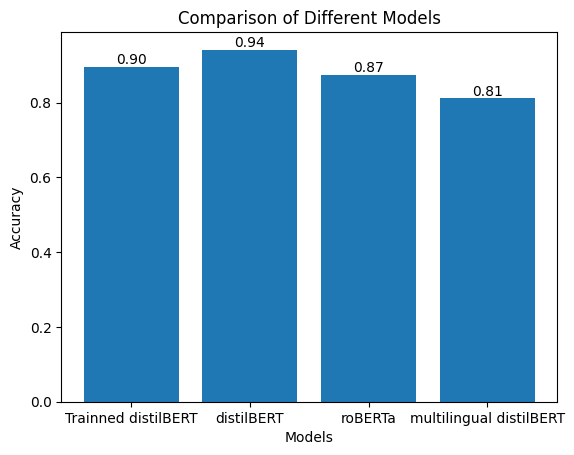

In [37]:
import matplotlib.pyplot as plt

# Labels for the bars
models = ['Trainned distilBERT', 'distilBERT', 'roBERTa', 'multilingual distilBERT']

# Values for each bar
values = [accuracy2, accuracy1, accuracy3, accuracy4]

plt.bar(models, values)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Different Models')

# Annotate bars with values
for i in range(len(models)):
    plt.text(i, values[i], "{:.2f}".format(values[i]), ha='center', va='bottom')


plt.show()
